# 2.1:  Computer Tomography: Forward Transform
Gruppe: Gabriel Wolf und Jakob Scheiber

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Unterpunkt a: Winkelbereich und Definitionsbereiche

Zuerst ist der Bereich, in dem $\varphi$ sein kann, gesucht. 

Mit einem Blick auf die Grafik 1 in der Angabe wird klar das sich der Winkel

zwischen 0° und exklusive 180° befinden kann.

Somit folgt $\varphi \in [0;180)$°

Wenn das Foto, bzw der Datensatz die Dimensionen M x N hat kann $\epsilon$ (also die Position entlang des Detektors)
 
 sich zwischen $-\frac{N}{2}$ und $+\frac{N}{2}$ hin und her schieben, also die Gesamte Bildbreite.

Somit folgt $\epsilon \in [-\frac{N}{2} ; \frac{N}{2}  ]$

Analog gilt das auch für $\eta$, nur muss hier bedacht werden, dass $\eta$ auch quer übers ganze Bild bzw. Körper zeigen kann.

Also folgt ganz einfach mit Geometrie $ \eta \in [ -\tfrac{1}{2}\sqrt{M^2 + N^2} ; \tfrac{1}{2}\sqrt{M^2 + N^2}]$


### Unterpunkt b: Evaluate Projections

In [8]:
data =np.loadtxt("Data/ring.txt", delimiter=',') 
print(data.shape) #ahh okay
M = data.shape[0] 
N= data.shape[1]

ksi_interval = np.linspace(-N/2 ,N/2 ,N) #Ksi Intervall
eta_interval = np.linspace(-np.sqrt((M**2)+(N**2))/2, np.sqrt((M**2)+(N**2))/2 ,M) #Eta Intervall
phi_interval = np.linspace(0, 1*np.pi, 180) #Phi Intervall

p_phi = np.zeros((len(phi_interval),len(ksi_interval))) #p array erzeugen
delta_eta = eta_interval[1] - eta_interval[0] #Schrittweite Eta

cx = (N-1) /2 #center x
cy = (M-1) /2  #center y

#Forward transform - 
for p in range(len(phi_interval)):
    phi = phi_interval[p]
    for i in range(N):
        ksi= ksi_interval[i]
        sum = 0
        for j in range(M):
            eta= eta_interval[j]
            x= ksi*np.cos(phi) - eta*np.sin(phi)
            y= ksi*np.sin(phi) + eta*np.cos(phi)
            x_int = int(np.round(x + cx)) 
            y_int = int(np.round(y + cy))
            if 0 <= x_int < N and 0 <= y_int < M: 
                sum= sum+data[y_int,x_int]
        p_phi[p,i] = sum*delta_eta

(360, 360)


### Unterpunkt c: Plotting

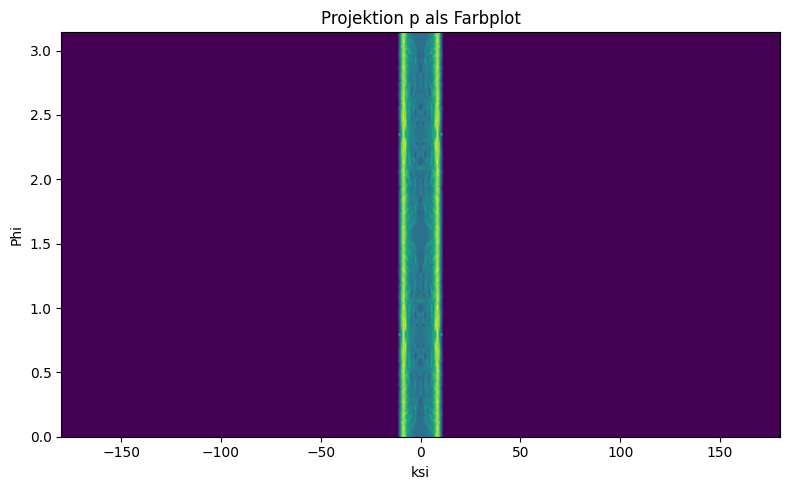

In [9]:
plt.figure(figsize=(8,5))
plt.imshow(
    p_phi,
    extent=[ksi_interval[0], ksi_interval[-1], phi_interval[0], phi_interval[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
plt.xlabel('ksi')
# plt.xlim(-30,30) # ranzoomen wenn man möchte
plt.ylabel('Phi')
plt.title('Projektion p als Farbplot')
plt.tight_layout()
plt.show()

### Unterpunkt d: Number of steps
Auswirkung der Steps von:

$\xi$: Verschmierung der Kanten der Säule, Schlechte horziontale Auflösung

$\eta$: Gibt die Schrittweite des Linienintegrals an, also analyiert die Genauigkeit

des Intensitätsabfalls, wählt man es zu groß, verschmieren die Farben des plots

bzw. der Abfall wird nicht genau genug aufgenommen.

$\varphi$: Steuert im Endeffekt wie viele Richtungen man projeziert

Minimum wäre bei $\xi$ und $\eta$ jeweils 1 pixel, da ja auch die Auflösung der Daten

nicht höher sein kann. Für $\varphi$ wäre es 1 Grad schätzungsweise (?) nochmal nachchecken sonst

### Unterpunkt e: Fourier components F (kξ cos φ, kξ sin φ)

In [10]:
delta_ksi = ksi_interval[1] - ksi_interval[0]
N_phi = len(phi_interval)
N_ksi = len(ksi_interval)

# Frequenzindizes m = -N/2 ... N/2-1
m = np.arange(-N_ksi//2, N_ksi//2, dtype=float)

# kξ-Werte entsprechend Gleichung (11)
kxi = (2*np.pi / (N_ksi * delta_ksi)) * m    # (N_ksi,)

# Matrix der Exponenten: e^{i kξ_m ξ_j}
E = np.exp(1j * np.outer(kxi, ksi_interval))  # (N_ksi, N_ksi)

# Fouriertransformierte für alle Winkel φ:
# F[p, m] = sum_j p_phi[p, j] * e^{i kξ_m ξ_j} * Δξ
F_phi = (E @ (p_phi.T * delta_ksi)).T         # (N_phi, N_ksi), komplex

# Umrechnung in kartesische Frequenzkoordinaten
cosphi = np.cos(phi_interval)[:, None]
sinphi = np.sin(phi_interval)[:, None]

kx = kxi[None, :] * cosphi    # (N_phi, N_ksi)
ky = kxi[None, :] * sinphi    # (N_phi, N_ksi)

### Unterpunkt f: Plot

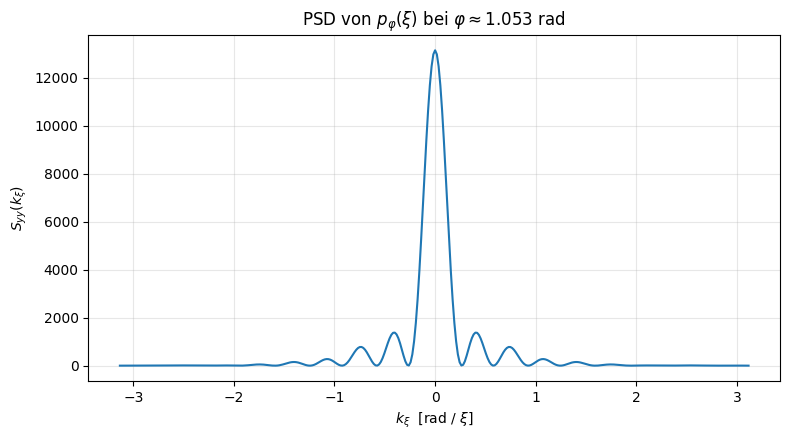

In [11]:
# 1) wähle einen Winkelindex p (frei wählbar)
p = 60                                  # z.B. φ ≈ phi_interval[60]
y = p_phi[p, :]                         # Signal entlang ξ
N_ksi = y.size

# 2) Δξ und zentrierte kξ-Stützstellen wie in (e)
delta_ksi = ksi_interval[1] - ksi_interval[0]
m = np.arange(-N_ksi//2, N_ksi//2, dtype=float)      # m = -N/2 ... N/2-1
kxi = (2.0*np.pi/(N_ksi*delta_ksi)) * m              # kξ in rad/ξ

# 3) Manuelle "DFT" à la (e): F(kξ) = Σ_j y(ξ_j) e^{i kξ ξ_j} Δξ  (keine FFT)
E = np.exp(1j * np.outer(kxi, ksi_interval))         # (N_ksi, N_ksi) mit e^{i kξ_m ξ_j}
F_kxi = E @ (y * delta_ksi)                          # (N_ksi,)

# 4) Power Spectral Density (bis auf globale Normierung wie in (12))
S = (np.abs(F_kxi)**2) / (N_ksi**2)                  # Form wie (12); Δξ steckt in F_kxi

# 5) Plot
plt.figure(figsize=(8,4.5))
plt.plot(kxi, S)
plt.xlabel(r'$k_\xi$  [rad / $\xi$]')
plt.ylabel(r'$S_{yy}(k_\xi)$')
plt.title(rf'PSD von $p_\varphi(\xi)$ bei $\varphi \approx {phi_interval[p]:.3f}$ rad')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
